In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
colab_dir = '/content/drive/MyDrive/Colab Notebooks'

In [4]:
!pip install nltk tensorflow_text pythainlp scikit-learn==1.2.2 scikeras==0.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 46.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [73]:
import numpy as np
import pandas as pd
import os
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, Attention, Input, Lambda, GlobalAveragePooling1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [4]:
tourism_reviews_en = pd.read_csv(f"{colab_dir}/eng_reviews_emotion_classify.csv")

In [95]:
tourism_reviews_en.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'helpful_votes', 'location_id', 'lang',
       'review_id', 'review', 'review_subject', 'trip_type', 'travel_date',
       'rating', 'location_name', 'province', 'place_id', 'cleaned_review',
       'emotion'],
      dtype='object')

In [5]:
tourism_reviews_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    5909 non-null   int64 
 1   Unnamed: 0      5909 non-null   int64 
 2   helpful_votes   5909 non-null   int64 
 3   location_id     5909 non-null   int64 
 4   lang            5909 non-null   object
 5   review_id       5909 non-null   int64 
 6   review          5909 non-null   object
 7   review_subject  5909 non-null   object
 8   trip_type       5892 non-null   object
 9   travel_date     5892 non-null   object
 10  rating          5909 non-null   int64 
 11  location_name   5909 non-null   object
 12  province        5909 non-null   object
 13  place_id        5909 non-null   object
 14  cleaned_review  5909 non-null   object
 15  emotion         5909 non-null   object
dtypes: int64(6), object(10)
memory usage: 738.8+ KB


In [6]:
tourism_reviews_en.head(5)

,Unnamed: 0.1,Unnamed: 0,helpful_votes,location_id,lang,review_id,review,review_subject,trip_type,travel_date,rating,location_name,province,place_id,cleaned_review,emotion
0,0,0,0,2209612,en,953596359,Besides elegant grand palace and wat pra kaew ...,"The place is nearby grand palace, in the area ...",Family,2024-05-31,5,Wat Ratchabophit,Bangkok,P03013220,besides elegant grand palace <OOV> wat pra kae...,joy
1,1,1,0,2209612,en,938998692,This is one of the last big king temples of Ba...,Nice Wat,Solo travel,2024-02-29,4,Wat Ratchabophit,Bangkok,P03013220,<OOV> <OOV> one <OOV> <OOV> last big king temp...,joy
2,2,2,6,2209612,en,933065689,"It is beautiful, clean and free to enter. Both...",Nice views,Solo travel,2023-12-31,4,Wat Ratchabophit,Bangkok,P03013220,<OOV> <OOV> beautiful clean <OOV> free <OOV> e...,joy
3,3,3,0,2209612,en,885904967,Wat Ratchabophit is a Buddhist temple located ...,Wat Ratchabophit - a temple characterized by u...,Couples,2022-10-31,5,Wat Ratchabophit,Bangkok,P03013220,wat ratchabophit <OOV> <OOV> buddhist temple l...,joy
4,4,4,4,2209612,en,782967555,Wat Ratchabophit is a historic royal temple bu...,"Beautiful, peaceful",NONE,2021-01-31,5,Wat Ratchabophit,Bangkok,P03013220,wat ratchabophit <OOV> <OOV> historic royal te...,joy


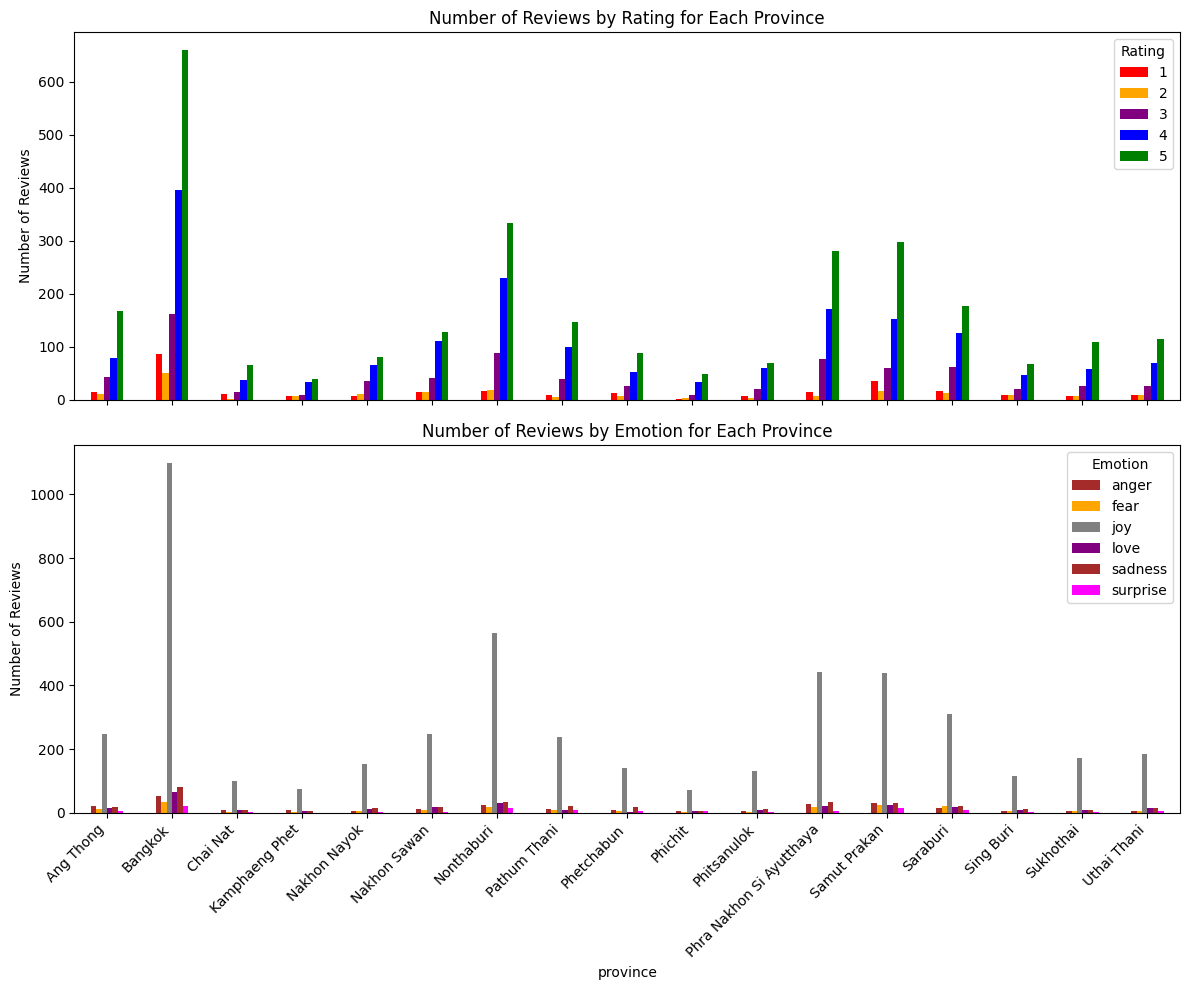

In [23]:

# จัดกลุ่มข้อมูลตาม province และ rating แล้วนับจำนวนรีวิว
rating_counts = tourism_reviews_en.groupby(['province', 'rating']).size().unstack(fill_value=0)

# จัดกลุ่มข้อมูลตาม province และ emotion แล้วนับจำนวนรีวิว
emotion_counts = tourism_reviews_en.groupby(['province', 'emotion']).size().unstack(fill_value=0)

# กำหนดสีสำหรับแต่ละ rating
rating_colors = {5: 'green', 4: 'blue', 3: 'purple', 2: 'orange', 1: 'red'}

# สร้าง palette ของสีสำหรับสุ่มสีของแต่ละ emotion
color_palette = ['red', 'green', 'blue', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan', 'magenta']

# สุ่มสีสำหรับแต่ละ emotion และทำให้สีนี้สามารถทำซ้ำได้
np.random.seed(42)
emotion_colors = {emotion: np.random.choice(color_palette) for emotion in emotion_counts.columns}

# สร้าง subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# กราฟสำหรับ ratings
rating_counts.plot(kind='bar', stacked=False, color=[rating_colors[rating] for rating in sorted(rating_counts.columns)], ax=ax1)
ax1.set_title('Number of Reviews by Rating for Each Province')
ax1.set_ylabel('Number of Reviews')
ax1.legend(title='Rating')

# กราฟสำหรับ emotions
emotion_counts.plot(kind='bar', stacked=False, color=[emotion_colors[emotion] for emotion in emotion_counts.columns], ax=ax2)
ax2.set_title('Number of Reviews by Emotion for Each Province')
ax2.set_ylabel('Number of Reviews')
ax2.legend(title='Emotion')

# หมุนป้ายแกน x
plt.xticks(rotation=45, ha="right")

# ปรับ layout เพื่อไม่ให้กราฟซ้อนทับกัน
plt.tight_layout()

# แสดงกราฟ
plt.show()


In [10]:
def clean_text(text):
    text = text.lower()  # แปลงข้อความเป็นตัวพิมพ์เล็ก
    text = re.sub(r'\[.*?\]', '', text)  # ลบเนื้อหาที่อยู่ในวงเล็บเหลี่ยม
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # ลบ URLs
    text = re.sub(r'<.*?>+', '', text)  # ลบ HTML tags
    text = re.sub(r'\n', '', text)  # ลบการขึ้นบรรทัดใหม่
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # เก็บเฉพาะตัวอักษร
    text = re.sub(r'\s+', ' ', text).strip()  # ลบช่องว่างที่ไม่จำเป็น
    return text

# Apply cleaning function to the 'review' column
tourism_reviews_en['cleaned_review'] = tourism_reviews_en['review'].apply(clean_text)


In [65]:
# 3. เตรียมข้อมูลข้อความและสร้าง Tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
tourism_reviews_en['cleaned_review'] = tourism_reviews_en['review'].apply(clean_text)
tokenizer.fit_on_texts(tourism_reviews_en['cleaned_review'])
word_index = tokenizer.word_index

# แปลงข้อความเป็นลำดับตัวเลข
X = tokenizer.texts_to_sequences(tourism_reviews_en['cleaned_review'])
X = pad_sequences(X, maxlen=100)

# เตรียม label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(tourism_reviews_en['location_id'])

In [37]:
# แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [52]:
!ls '/content/drive/MyDrive/Colab Notebooks'

 embedding_vectors.npy		   'Test Model Script'
 eng_reviews_emotion_classify.csv   text_sentiment_model.ipynb
 glove.6B.zip			    tourism_reviews_en_tokenize.csv
 lstm_model_sample.h5		    transform_and_normalize_reviews.ipynb
 Models				    TripAdvisor_reviews_EN.csv
 sample_5_reviews_en.csv


In [63]:
!unzip '/content/drive/MyDrive/Colab Notebooks/glove.6B.zip' -d '/content/drive/MyDrive/Colab Notebooks'

Archive:  /content/drive/MyDrive/Colab Notebooks/glove.6B.zip
replace /content/drive/MyDrive/Colab Notebooks/glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/Colab Notebooks/glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/Colab Notebooks/glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [64]:
embeddings_index = {}
with open(os.path.join(colab_dir, 'glove.6B.100d.txt'), encoding="utf8") as f:  # ระบุไฟล์ GloVe ที่ถูกแตกออกมา
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [66]:
# 3. การใช้ Pre-trained Embeddings (ใช้ Universal Sentence Encoder แบบ fine-tuned)
# embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5", trainable=True)

# 4. สร้าง Embedding Matrix
embedding_dim = 100  # ต้องตรงกับไฟล์ GloVe ที่คุณใช้ (glove.6B.100d.txt มี 100 มิติ)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [81]:
# 5. สร้างโมเดล Keras ด้วย Embedding Layer ที่กำหนดเองจาก GloVe
input_text = Input(shape=(100,), dtype='int32')
embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=True)(input_text)

# ใช้ GlobalAveragePooling1D เพื่อแปลงผลลัพธ์ให้เป็นเวกเตอร์เดียว
pooled_output = GlobalAveragePooling1D()(embedding_layer)

# dense_1 = Dense(128, activation='relu')(pooled_output)
# dropout_1 = Dropout(0.5)(dense_1)
# dense_2 = Dense(64, activation='relu')(dropout_1)
# dropout_2 = Dropout(0.5)(dense_2)
# output = Dense(len(label_encoder.classes_), activation='softmax')(dropout_2)

dense_1 = Dense(64, activation='relu')(pooled_output)
dropout_1 = Dropout(0.5)(dense_1)
output = Dense(len(label_encoder.classes_), activation='softmax')(dropout_1)


# 6. สร้างโมเดล
CNN_model = Model(inputs=[input_text], outputs=[output])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [82]:
from tensorflow.keras.utils import to_categorical

# ปรับ Hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # ปรับ learning rate

# Convert y_train and y_test to one-hot encoded labels
y_train_categorical = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test_categorical = to_categorical(y_test, num_classes=len(label_encoder.classes_))

# Compile model with categorical_crossentropy
CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




In [83]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [85]:
history = CNN_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 3.4761e-04 - loss: 7.2680 - val_accuracy: 0.0000e+00 - val_loss: 7.2688
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.0014 - loss: 7.2307 - val_accuracy: 0.0000e+00 - val_loss: 7.3191
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 9.1579e-04 - loss: 7.1217 - val_accuracy: 0.0000e+00 - val_loss: 7.4041
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0023 - loss: 7.0308 - val_accuracy: 0.0000e+00 - val_loss: 7.4437
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.0044 - loss: 6.9260 - val_accuracy: 0.0000e+00 - val_loss: 7.4715
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.0062 - loss: 6.8551 - val_accuracy: 8.4602e-04 - val_loss: 7.4638
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.0058 - loss: 6.7692 - val_accuracy: 8.4602e-04 - val_loss: 7.5134
Epoch 8/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accura

In [86]:
# from tensorflow.keras.models import load_model
# Save the trained model
CNN_model.save(f'{colab_dir}/Models/lstm_model_sample.h5')
# lstm_model = load_model(f'{colab_dir}/Models/lstm_model_sample.h5')


In [87]:
test_loss, test_accuracy = CNN_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0104 - loss: 8.4483
Test Accuracy: 0.01


In [89]:
def recommend_place(review_text):
    # Preprocess the input review
    sequence = tokenizer.texts_to_sequences([review_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)

    # Predict the place ID
    predicted_class = CNN_model.predict(padded_sequence)
    predicted_label = np.argmax(predicted_class, axis=-1)

    # Convert the predicted label back to place ID or name
    recommended_place = label_encoder.inverse_transform(predicted_label)

    return recommended_place[0]

# Example usage
sample_review = "water market"
recommended_place = recommend_place(sample_review)
print(f"Recommended place: {recommended_place}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Recommended place: 14928814


In [90]:
tourism_reviews_en[tourism_reviews_en['location_id'] == recommended_place]

,Unnamed: 0.1,Unnamed: 0,helpful_votes,location_id,lang,review_id,review,review_subject,trip_type,travel_date,rating,location_name,province,place_id,cleaned_review,emotion
2356,2356,2356,0,14928814,en,951150271,Perfect for a romantic and relaxing retreat. H...,.,Couples,2024-05-31,5,The Wora Spa Hua Hin,Chai Nat,P03008066,perfect for a romantic and relaxing retreat hi...,love
2357,2357,2357,0,14928814,en,951149937,"Every detail is meticulously attended to, maki...",love,Solo travel,2024-05-31,5,The Wora Spa Hua Hin,Chai Nat,P03008066,every detail is meticulously attended to makin...,joy
2358,2358,2358,0,14928814,en,949128127,"I opted for their signature massage treatment,...",Amazing,Friends getaway,2024-04-30,5,The Wora Spa Hua Hin,Chai Nat,P03008066,i opted for their signature massage treatment ...,joy
2359,2359,2359,0,14928814,en,948897159,"The spa's minimalist decor, paired with soft l...",Good,Family,2024-04-30,5,The Wora Spa Hua Hin,Chai Nat,P03008066,the spa s minimalist decor paired with soft li...,love
2360,2360,2360,0,14928814,en,943849752,"Upon arrival, I was greeted by a warm and invi...",relaxation,Solo travel,2024-03-31,5,The Wora Spa Hua Hin,Chai Nat,P03008066,upon arrival i was greeted by a warm and invit...,love


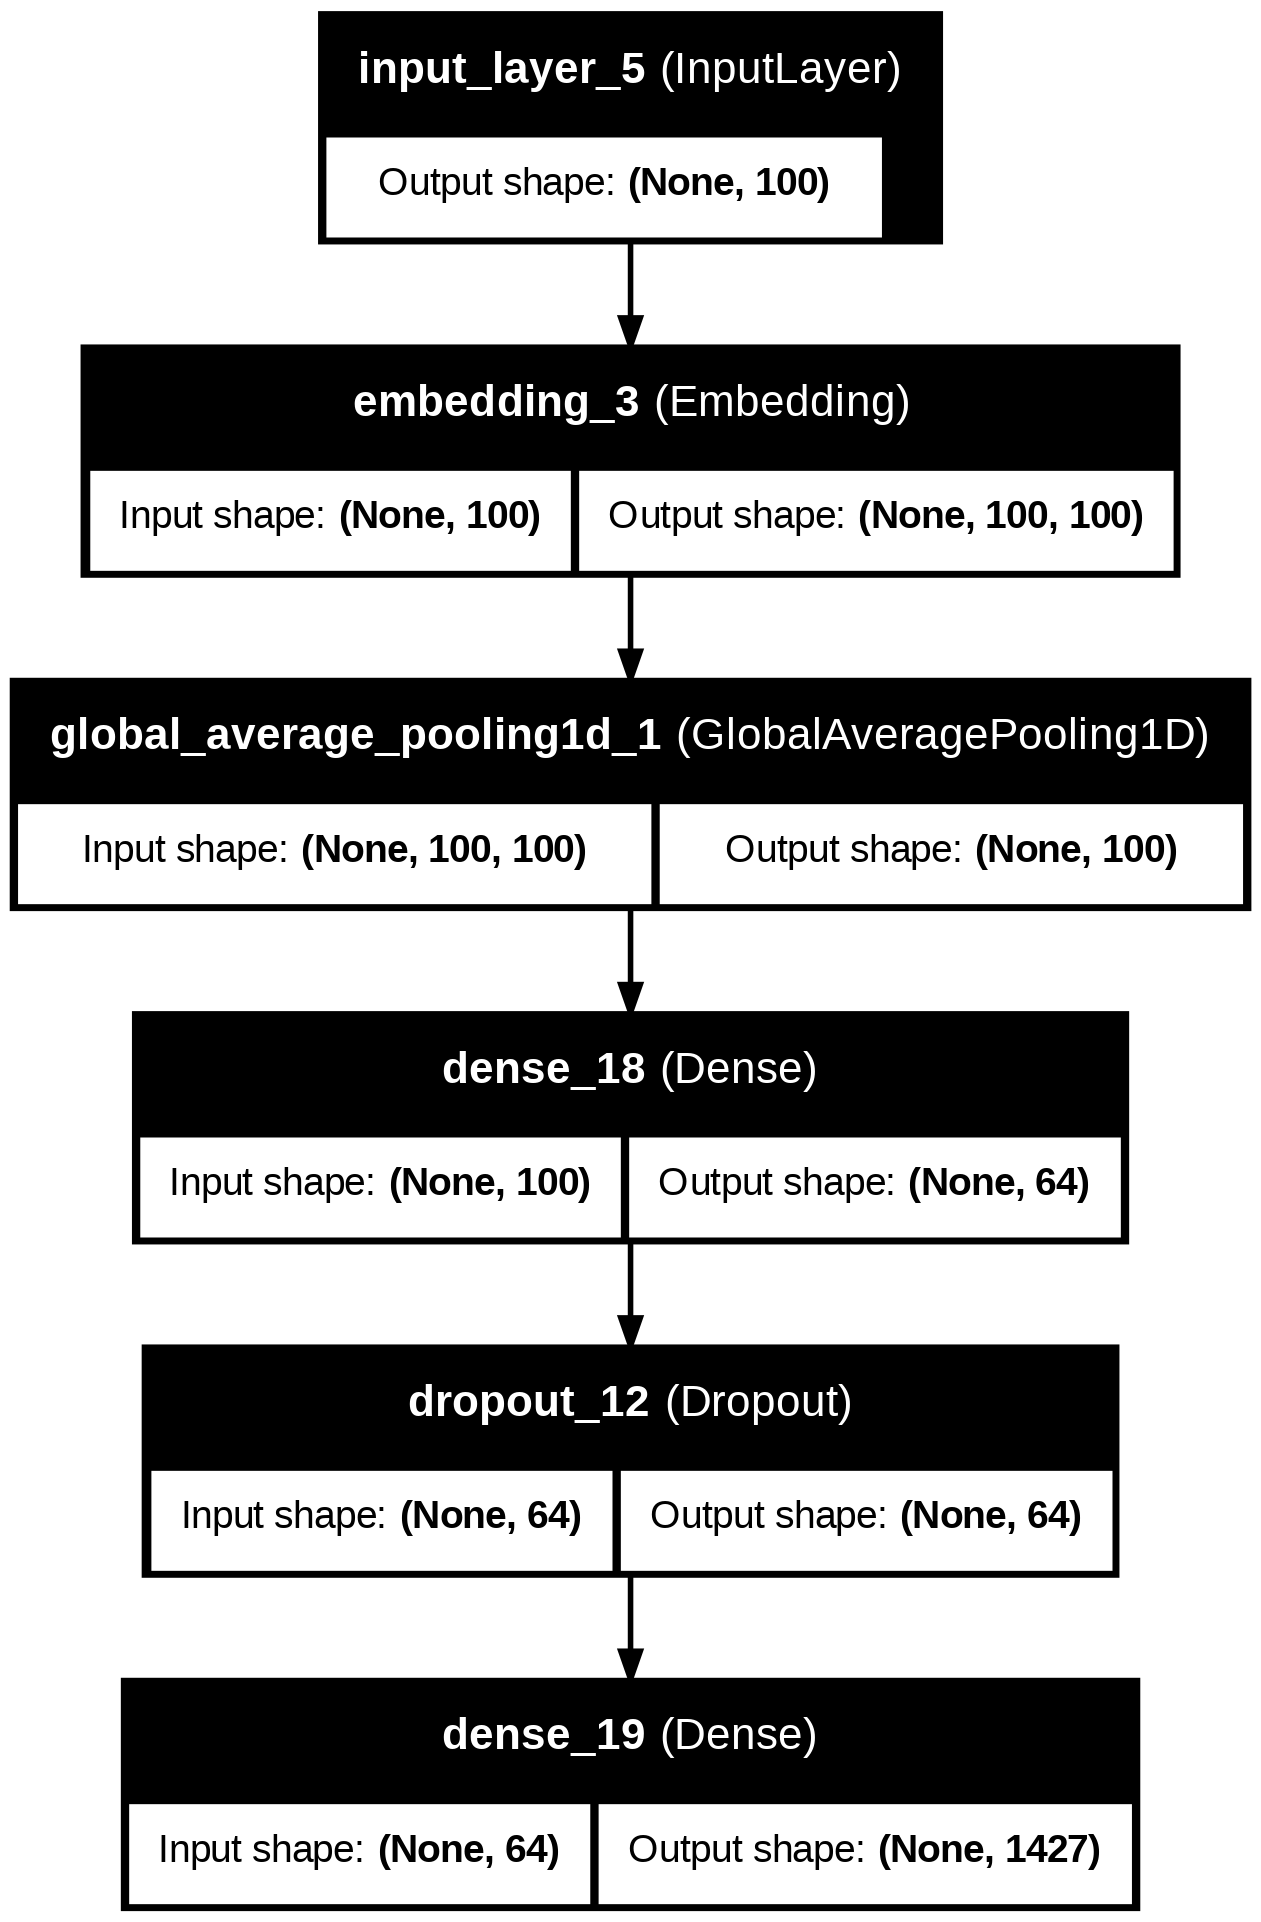

In [91]:
# Visualize the model architecture
plot_model(CNN_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [92]:
# Display model summary
CNN_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 100, 100)            │       1,710,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 100)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1427)                │          92,755 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,427,659 (20.70 MB)

 Trainable params: 1,809,219 (6.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,618,440 (13.80 MB)

In [93]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

lstm_pred = np.argmax(CNN_model.predict(X_test), axis=-1)
accuracy = accuracy_score(y_test, lstm_pred)
print("Accuracy:", accuracy)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Accuracy: 0.008460236886632826


Exception ignored in: <function _xla_gc_callback at 0x7aa17bbd9d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7aa1fe0613f0> (for post_execute):


KeyboardInterrupt: 

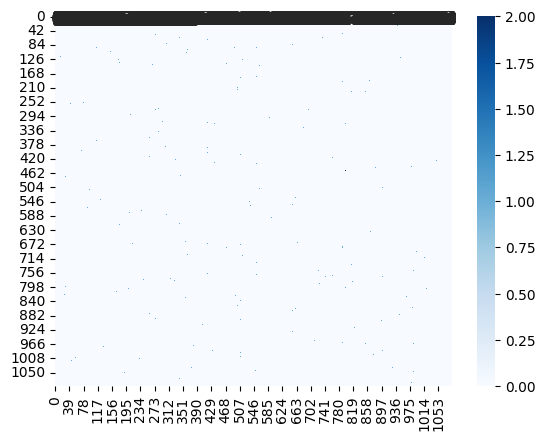

In [94]:

conf_matrix = confusion_matrix(y_test, lstm_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
print(classification_report(y_test, lstm_pred, target_names='emotion'))


In [ ]:
from tensorflow.keras.metrics import top_k_categorical_accuracy

def top_k_accuracy(y_true, y_pred, k=5):
    return top_k_categorical_accuracy(y_true, y_pred, k=k)

# Example usage with Top-5 accuracy
lstm_pred_prob = lstm_model.predict(X_test)
top_5_accuracy = top_k_accuracy(y_test, lstm_pred_prob, k=5)
print("Top-5 Accuracy:", np.mean(top_5_accuracy))


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step


InvalidArgumentError: {{function_node __wrapped__InTopKV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} targets must be 1-dimensional [Op:InTopKV2] name: 

In [ ]:
# ROC Curve and AUC

fpr, tpr, thresholds = roc_curve(y_test, lstm_pred_prob[:, 1])
auc = roc_auc_score(y_test, lstm_pred_prob[:, 1])

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

ValueError: multiclass format is not supported

In [ ]:
def mean_reciprocal_rank(y_true, y_pred):
    ranks = []
    for true, pred in zip(y_true, y_pred):
        rank = np.where(np.argsort(pred)[::-1] == true)[0][0] + 1
        ranks.append(1 / rank)
    return np.mean(ranks)

mrr = mean_reciprocal_rank(y_test, lstm_pred_prob)
print("Mean Reciprocal Rank (MRR):", mrr)


Mean Reciprocal Rank (MRR): 0.0045175638527143284


In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

NameError: name 'history' is not defined

<Figure size 1200x600 with 0 Axes>